# Importing libraries

In [318]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Death prediction in Colombia due to covid-19.

In [ ]:
df = pd.read_csv('Casos_positivos_de_COVID-19_en_Colombia._20241128.csv')

## 1. Data Collection

The dataset that we found is too big (more than 6.3M of records) and the features are written in spanish, which doesn't help us for cleaning it.

We will then rename columns, and use a small sample (more precisely 1% of the original dataset) to export it to another file.

Doing so, we will have readable input variables in english, and a file that will allow us to use less computing ressources.

### Renaming columns

In [ ]:
column_mapping = {
    "fecha reporte web": "report_date",
    "ID de caso": "case_id",
    "Fecha de notificación": "notification_date",
    "Código DIVIPOLA departamento": "department_code",
    "Nombre departamento": "department_name",
    "Código DIVIPOLA municipio": "municipality_code",
    "Nombre municipio": "municipality_name",
    "Edad": "age",
    "Unidad de medida de edad": "age_unit",
    "Sexo": "gender",
    "Tipo de contagio": "contagion_type",
    "Ubicación del caso": "case_location",
    "Estado": "status",
    "Código ISO del país": "country_iso_code",
    "Nombre del país": "country_name",
    "Recuperado": "recovered",
    "Fecha de inicio de síntomas": "symptom_start_date",
    "Fecha de muerte": "death_date",
    "Fecha de diagnóstico": "diagnosis_date",
    "Fecha de recuperación": "recovery_date",
    "Tipo de recuperación": "recovery_type",
    "Pertenencia étnica": "ethnic_affiliation",
    "Nombre del grupo étnico": "ethnic_group_name",
}
df.rename(columns=column_mapping, inplace=True)

### Keeping 1% of dataset using Random Sampling Technique (from pandas library), and exporting it to another file

In [29]:
df_sample = df.sample(frac=0.01, random_state=42)

In [ ]:
print(f"Percentage of deaths: {int(df_sample[df_sample['death_date'].notna()]['death_date'].count()) / int(df_sample['case_id'].count()) * 100} %")

#### We notice that, we have a lot of class unbalancing, and then this sample doesn't suit us to build a model, so we are going to re-collect our data from the big dataset, in order to have as much records with death_date as without.

### Sampling the dataset in 2 sub-samples (no-death, & death), and combining them

In [122]:
df_no_death = df[df['death_date'].isna()]
df_no_death_sample = df_no_death.sample(frac=0.004, random_state=42)

In [123]:
df_death = df[df['death_date'].notna()]
df_death_sample = df_death.sample(frac=0.13, random_state=42)

In [124]:
df_final_sample = pd.concat([df_no_death_sample, df_death_sample])
df_final_sample = df_final_sample.sample(frac=1, random_state=42).reset_index(drop=True)

In [125]:
df_final_sample.to_csv('covid19_sample.csv', index=False)

In [ ]:
print(f"Percentage of deaths: {int(df_final_sample[df_final_sample['death_date'].notna()]['death_date'].count()) / int(df_final_sample['case_id'].count()) * 100} %")

## 2. Data Understanding

### Loading the sample that we exported previously

In [330]:
df = pd.read_csv('covid19_sample.csv')

### Displaying the dataframe with additional info

In [331]:
df.shape

(48797, 23)

In [332]:
df

,report_date,case_id,notification_date,department_code,department_name,municipality_code,municipality_name,age,age_unit,gender,...,country_iso_code,country_name,recovered,symptom_start_date,death_date,diagnosis_date,recovery_date,recovery_type,ethnic_affiliation,ethnic_group_name
0,2021-05-27 00:00:00,3303012,2021-05-25 00:00:00,76,VALLE,76318,GUACARI,60,1,F,...,NaN,NaN,Recuperado,2021-05-17 00:00:00,NaN,2021-05-26 00:00:00,2021-06-01 00:00:00,Tiempo,6.0,NaN
1,2020-10-12 00:00:00,912103,2020-10-05 00:00:00,68,SANTANDER,68081,BARRANCABERMEJA,86,1,M,...,NaN,NaN,NaN,2020-09-29 00:00:00,2021-02-12 00:00:00,2020-10-11 00:00:00,NaN,NaN,6.0,NaN
2,2021-03-31 00:00:00,2397852,2021-03-18 00:00:00,8,ATLANTICO,8758,SOLEDAD,40,1,F,...,NaN,NaN,Recuperado,2021-03-16 00:00:00,NaN,2021-03-29 00:00:00,2021-04-01 00:00:00,Tiempo,6.0,NaN
3,2021-05-25 00:00:00,3264190,2021-05-21 00:00:00,11,BOGOTA,11001,BOGOTA,35,1,M,...,NaN,NaN,Recuperado,NaN,NaN,2021-05-22 00:00:00,2021-06-04 00:00:00,Tiempo,6.0,NaN
4,2022-02-07 00:00:00,5974914,2022-01-23 00:00:00,44,GUAJIRA,44001,RIOHACHA,18,1,F,...,NaN,NaN,Recuperado,2022-01-19 00:00:00,NaN,2022-02-03 00:00:00,2022-02-08 00:00:00,Tiempo,6.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48792,2021-05-26 00:00:00,3282457,2021-05-23 00:00:00,76,VALLE,76001,CALI,66,1,F,...,NaN,NaN,Recuperado,2021-05-14 00:00:00,NaN,2021-05-26 00:00:00,2021-05-28 00:00:00,Tiempo,6.0,NaN
48793,2020-09-25 00:00:00,791713,2020-09-23 00:00:00,76,VALLE,76520,PALMIRA,67,1,M,...,NaN,NaN,Fallecido,2020-09-21 00:00:00,2020-09-28 00:00:00,2020-09-23 00:00:00,NaN,NaN,6.0,NaN
48794,2021-07-13 00:00:00,4542060,2021-07-08 00:00:00,11,BOGOTA,11001,BOGOTA,23,1,M,...,NaN,NaN,NaN,2021-07-04 00:00:00,2021-10-14 00:00:00,2021-07-12 00:00:00,NaN,NaN,6.0,NaN
48795,2021-06-12 00:00:00,3714232,2021-06-03 00:00:00,11,BOGOTA,11001,BOGOTA,19,1,M,...,NaN,NaN,Recuperado,NaN,NaN,2021-06-04 00:00:00,2021-06-17 00:00:00,Tiempo,6.0,NaN


In [333]:
df.head()

,report_date,case_id,notification_date,department_code,department_name,municipality_code,municipality_name,age,age_unit,gender,...,country_iso_code,country_name,recovered,symptom_start_date,death_date,diagnosis_date,recovery_date,recovery_type,ethnic_affiliation,ethnic_group_name
0,2021-05-27 00:00:00,3303012,2021-05-25 00:00:00,76,VALLE,76318,GUACARI,60,1,F,...,NaN,NaN,Recuperado,2021-05-17 00:00:00,NaN,2021-05-26 00:00:00,2021-06-01 00:00:00,Tiempo,6.0,NaN
1,2020-10-12 00:00:00,912103,2020-10-05 00:00:00,68,SANTANDER,68081,BARRANCABERMEJA,86,1,M,...,NaN,NaN,NaN,2020-09-29 00:00:00,2021-02-12 00:00:00,2020-10-11 00:00:00,NaN,NaN,6.0,NaN
2,2021-03-31 00:00:00,2397852,2021-03-18 00:00:00,8,ATLANTICO,8758,SOLEDAD,40,1,F,...,NaN,NaN,Recuperado,2021-03-16 00:00:00,NaN,2021-03-29 00:00:00,2021-04-01 00:00:00,Tiempo,6.0,NaN
3,2021-05-25 00:00:00,3264190,2021-05-21 00:00:00,11,BOGOTA,11001,BOGOTA,35,1,M,...,NaN,NaN,Recuperado,NaN,NaN,2021-05-22 00:00:00,2021-06-04 00:00:00,Tiempo,6.0,NaN
4,2022-02-07 00:00:00,5974914,2022-01-23 00:00:00,44,GUAJIRA,44001,RIOHACHA,18,1,F,...,NaN,NaN,Recuperado,2022-01-19 00:00:00,NaN,2022-02-03 00:00:00,2022-02-08 00:00:00,Tiempo,6.0,NaN


In [334]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48797 entries, 0 to 48796
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   report_date         48797 non-null  object 
 1   case_id             48797 non-null  int64  
 2   notification_date   48797 non-null  object 
 3   department_code     48797 non-null  int64  
 4   department_name     48797 non-null  object 
 5   municipality_code   48797 non-null  int64  
 6   municipality_name   48797 non-null  object 
 7   age                 48797 non-null  int64  
 8   age_unit            48797 non-null  int64  
 9   gender              48797 non-null  object 
 10  contagion_type      48797 non-null  object 
 11  case_location       43391 non-null  object 
 12  status              43391 non-null  object 
 13  country_iso_code    39 non-null     float64
 14  country_name        39 non-null     object 
 15  recovered           44063 non-null  object 
 16  symp

In [335]:
df.describe()

,case_id,department_code,municipality_code,age,age_unit,country_iso_code,ethnic_affiliation
count,4.879700e+04,48797.000000,48797.000000,48797.000000,48797.000000,39.000000,48784.000000
mean,3.063136e+06,1333.884399,30586.295018,53.571879,1.004427,567.743590,5.904866
std,1.880610e+06,6040.837648,26888.110392,22.675508,0.072012,334.770677,0.611432
min,1.140000e+02,5.000000,5001.000000,1.000000,1.000000,8.000000,1.000000
25%,1.445576e+06,11.000000,11001.000000,35.000000,1.000000,201.000000,6.000000
50%,2.963218e+06,20.000000,15001.000000,55.000000,1.000000,840.000000,6.000000
75%,4.664492e+06,68.000000,54001.000000,72.000000,1.000000,840.000000,6.000000
max,6.390842e+06,47001.000000,99773.000000,108.000000,3.000000,862.000000,6.000000


### Detect issues that have to be fixed later during the pre-processing part

#### Checking for missing values

In [336]:
df.isnull().sum()

report_date               0
case_id                   0
notification_date         0
department_code           0
department_name           0
municipality_code         0
municipality_name         0
age                       0
age_unit                  0
gender                    0
contagion_type            0
case_location          5406
status                 5406
country_iso_code      48758
country_name          48758
recovered              4734
symptom_start_date     2175
death_date            24826
diagnosis_date           27
recovery_date         23308
recovery_type         23315
ethnic_affiliation       13
ethnic_group_name     48099
dtype: int64

In [337]:
# Function to calculate missing values by column
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Percentage of missing values beyond 30%
    mis_val_percent_more_than_threshold = mis_val_percent > 30

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent, mis_val_percent_more_than_threshold], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Counts', 1 : 'Percentage', 2 : 'More than 30% missing'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        'Percentage', ascending=False).round(1)

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

missing_values_table(df)

,Missing Counts,Percentage,More than 30% missing
country_name,48758,99.9,True
country_iso_code,48758,99.9,True
ethnic_group_name,48099,98.6,True
death_date,24826,50.9,True
recovery_type,23315,47.8,True
recovery_date,23308,47.8,True
case_location,5406,11.1,False
status,5406,11.1,False
recovered,4734,9.7,False
symptom_start_date,2175,4.5,False


In [338]:
threshold = 0.3
for column in df.columns:
    nan_ratio = df[column].isna().mean()
    if nan_ratio > threshold:
        print(f"Column '{column}' has more than 30% NaN values: {nan_ratio:.2%}")
print('---------------------------------------------------------------')
for column in df.columns:
    nan_ratio = df[column].isna().mean()
    if nan_ratio < threshold and nan_ratio != 0:
        print(f"Column '{column}' has less than 30% NaN values: {nan_ratio:.2%}")

Column 'country_iso_code' has more than 30% NaN values: 99.92%
Column 'country_name' has more than 30% NaN values: 99.92%
Column 'death_date' has more than 30% NaN values: 50.88%
Column 'recovery_date' has more than 30% NaN values: 47.77%
Column 'recovery_type' has more than 30% NaN values: 47.78%
Column 'ethnic_group_name' has more than 30% NaN values: 98.57%
---------------------------------------------------------------
Column 'case_location' has less than 30% NaN values: 11.08%
Column 'status' has less than 30% NaN values: 11.08%
Column 'recovered' has less than 30% NaN values: 9.70%
Column 'symptom_start_date' has less than 30% NaN values: 4.46%
Column 'diagnosis_date' has less than 30% NaN values: 0.06%
Column 'ethnic_affiliation' has less than 30% NaN values: 0.03%


#### Detect duplicated records

In [339]:
duplicates = df.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

Number of duplicate rows: 0


#### Correlation Analysis with correlation matrix

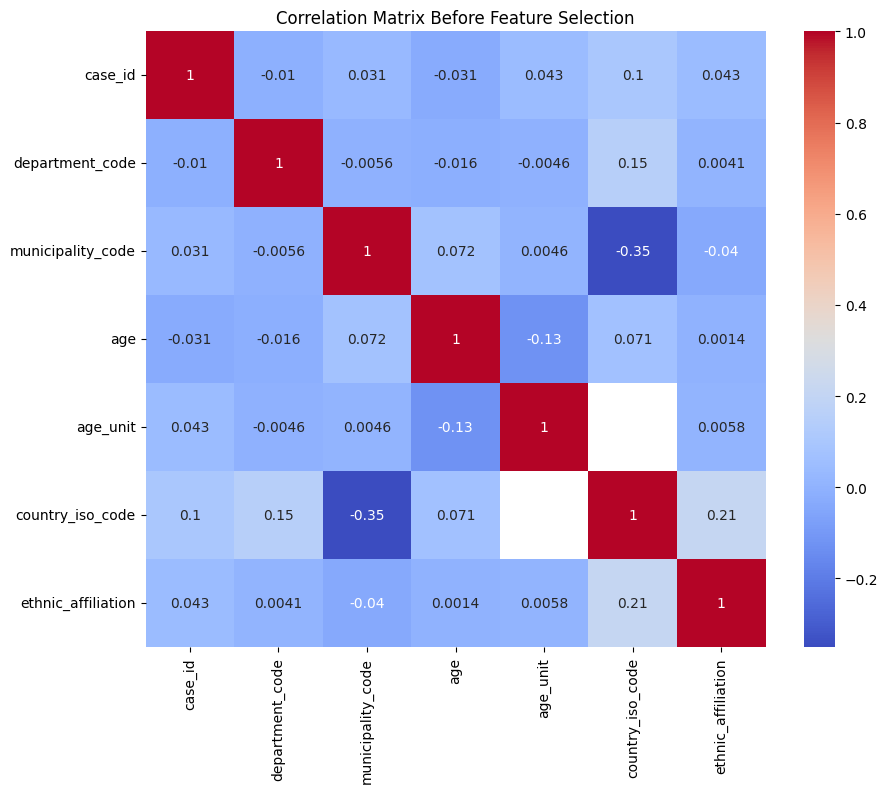

In [340]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df[numeric_cols].corr()

# Visualize correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Before Feature Selection')
plt.show()

## 3. Data Pre-processing

We can see that we have a lot of irrelevant data, missing values, class inbalancing, date columns to be replaced, categorical variables to be encoded, and so on.

So let's clear our data...

### Dropping/filling missing values

#### From Data Understanding part :

In [341]:
missing_values_table(df)

,Missing Counts,Percentage,More than 30% missing
country_name,48758,99.9,True
country_iso_code,48758,99.9,True
ethnic_group_name,48099,98.6,True
death_date,24826,50.9,True
recovery_type,23315,47.8,True
recovery_date,23308,47.8,True
case_location,5406,11.1,False
status,5406,11.1,False
recovered,4734,9.7,False
symptom_start_date,2175,4.5,False


In [342]:
columns_drop = ['country_name', 'country_iso_code', 'recovery_date', 'recovery_type', 'ethnic_group_name']
columns_fill = ['case_location', 'status', 'recovered', 'symptom_start_date', 'diagnosis_date', 'ethnic_affiliation']
df.drop(columns=columns_drop, axis=1, inplace=True)
for column in columns_fill:
    if df[column].dtype == 'object':
        df[column].fillna(df[column].value_counts().index[0], inplace=True)
    else:
        df[column].fillna(df[column].mean(), inplace=True)

C:\Users\squip\AppData\Local\Temp\ipykernel_20784\4265019457.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].value_counts().index[0], inplace=True)
C:\Users\squip\AppData\Local\Temp\ipykernel_20784\4265019457.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves 

#### Making sure there are no missing values anymore, except for death_date that will be transformed later

In [343]:
df.isnull().sum()

report_date               0
case_id                   0
notification_date         0
department_code           0
department_name           0
municipality_code         0
municipality_name         0
age                       0
age_unit                  0
gender                    0
contagion_type            0
case_location             0
status                    0
recovered                 0
symptom_start_date        0
death_date            24826
diagnosis_date            0
ethnic_affiliation        0
dtype: int64

### Transforming our Target Variable (death_date) to boolean values, and renaming it

In [344]:
df['is_dead'] = df['death_date'].notna()
df.drop(columns=['death_date'], inplace=True)

### Filtering relevant features

In [345]:
relevant_features = [
    "department_code", "age", "gender", "contagion_type", "case_location",
    "symptom_start_date", "diagnosis_date", "is_dead"
    ]
df = df[relevant_features]


### Converting date columns

In [346]:
date_columns = ["symptom_start_date", "diagnosis_date"]
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

C:\Users\squip\AppData\Local\Temp\ipykernel_20784\1469152063.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_datetime(df[col], errors='coerce')
C:\Users\squip\AppData\Local\Temp\ipykernel_20784\1469152063.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_datetime(df[col], errors='coerce')


### Visualize outliers

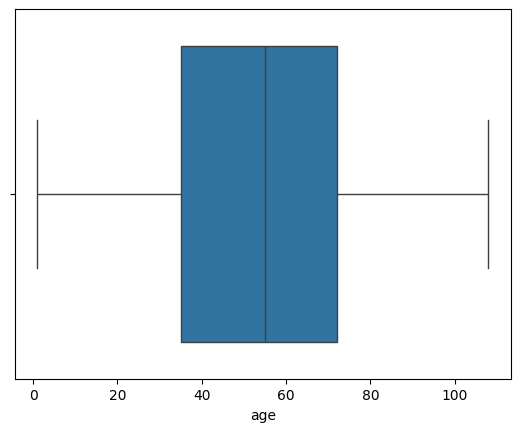

In [347]:
sns.boxplot(data=df, x='age')
plt.show()

### Visualize distribution

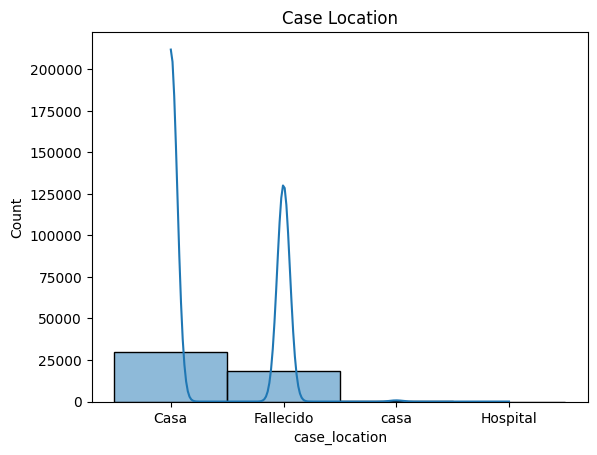

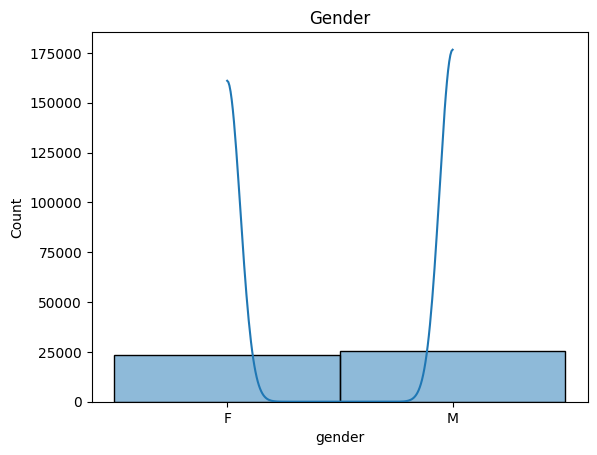

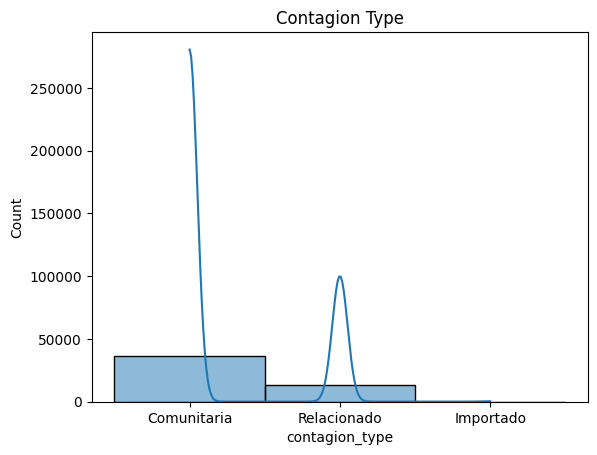

In [348]:
sns.histplot(df['case_location'], kde=True)
plt.title('Case Location')
plt.show()
sns.histplot(df['gender'], kde=True)
plt.title('Gender')
plt.show()
sns.histplot(df['contagion_type'], kde=True)
plt.title('Contagion Type')
plt.show()

In [349]:
df['case_location'].value_counts()

case_location
Casa         30123
Fallecido    18565
casa           104
Hospital         5
Name: count, dtype: int64

In [350]:
df['contagion_type'].value_counts()

contagion_type
Comunitaria    35937
Relacionado    12821
Importado         39
Name: count, dtype: int64

### Dropping records with 'casa' and 'Hospital' as Case location, and with 'Importado' as Contagion Type because they are insignificant

In [351]:
df = df[~df['case_location'].isin(['casa', 'Hospital'])]
df = df[df['contagion_type'] != 'Importado']

### Encoding categorical variables

In [352]:
label_encoder = LabelEncoder()
df['gender'] = label_encoder.fit_transform(df['gender'])
df['contagion_type'] = label_encoder.fit_transform(df['contagion_type'])
df['case_location'] = label_encoder.fit_transform(df['case_location'])

df['symptom_start_date'] = label_encoder.fit_transform(df['symptom_start_date'])
df['diagnosis_date'] = label_encoder.fit_transform(df['diagnosis_date'])
df['is_dead'] = label_encoder.fit_transform(df['is_dead'])

### Normalizing numeric features

In [353]:
scaler = StandardScaler()
df['age'] = scaler.fit_transform(df[['age']])

In [354]:
df.head()

,department_code,age,gender,contagion_type,case_location,symptom_start_date,diagnosis_date,is_dead
0,76,0.282246,0,0,0,425,423,0
1,68,1.428915,1,1,0,195,196,1
2,8,-0.599808,0,1,0,363,365,0
3,11,-0.820321,1,0,0,656,419,0
4,44,-1.570067,0,0,0,672,676,0


### Making sure the variables are not too much correlated

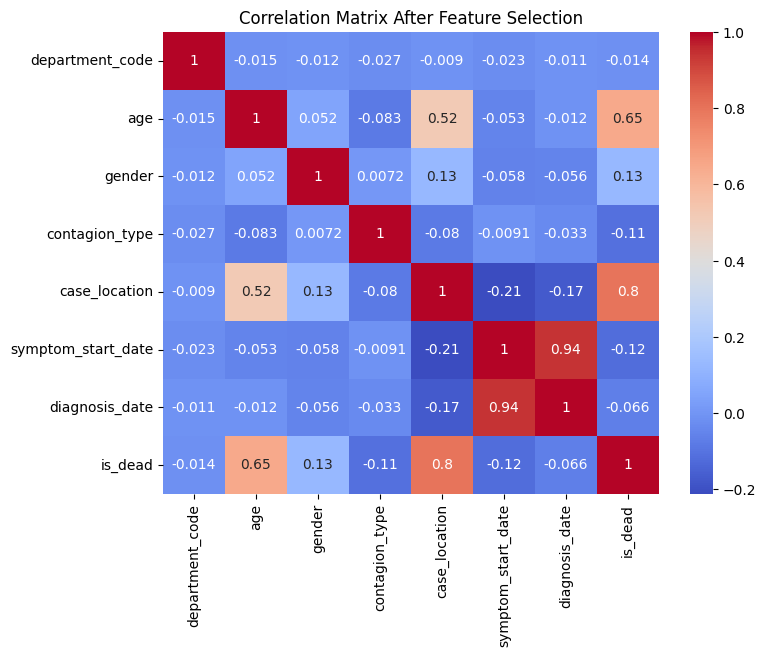

In [355]:
numeric_cols_selected = df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix_selected = df[numeric_cols_selected].corr()

# Visualize
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_selected, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix After Feature Selection')
plt.show()

### symptom_start_date & diagnosis_date are too much correlated, let's keep only one of them

In [356]:
df.drop(columns=['symptom_start_date'], axis=1, inplace=True)

## 4. Data split

In [357]:
X = df.drop(columns=['is_dead'])
y = df['is_dead']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 5. KNN: Death prediction in Colombia due to covid-19.

### Standardization, to put all the features on a comparable scale

In [358]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Data Training

In [359]:
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train, y_train)

KNeighborsClassifier()

### Data Testing/Evaluation before HP Tuning

#### Accuracy, precision, recall, f1 score

In [360]:
y_pred = knn.predict(X_test)

knn_acc = accuracy_score(y_test, y_pred)*100
knn_pre = precision_score(y_test, y_pred, average = 'micro')
knn_recall = recall_score(y_test, y_pred, average = 'micro')
knn_f1_ = f1_score(y_test, y_pred, average = 'micro')

print("KNN - Accuracy: {:.3f}.".format(knn_acc))
print("KNN - Precision: {:.3f}.".format(knn_pre))
print("KNN - Recall: {:.3f}.".format(knn_recall))
print("KNN - F1_Score: {:.3f}.".format(knn_f1_))

print("\nClassification report:")
print(classification_report(y_test, y_pred))

KNN - Accuracy: 91.764.
KNN - Precision: 0.918.
KNN - Recall: 0.918.
KNN - F1_Score: 0.918.

Classification report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7342
           1       0.94      0.89      0.92      7253

    accuracy                           0.92     14595
   macro avg       0.92      0.92      0.92     14595
weighted avg       0.92      0.92      0.92     14595



#### Confusion Matrix

Confusion matrix:
[[6908  434]
 [ 768 6485]]


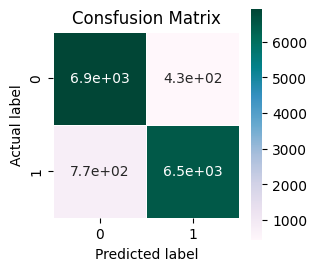

In [361]:
print("Confusion matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, linewidths=.5, square = True, cmap = 'PuBuGn');
plt.xlabel('Predicted label');
plt.ylabel('Actual label');
plt.title("Consfusion Matrix", size = 12);

### HP Tuning

In [ ]:
parameters = {
    'n_neighbors': np.arange(5, 7, 1),
    'weights' : ['uniform', 'distance'],
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': np.arange(30, 50, 1),
    'p' : (1,2) # p=1 for manhattan_distance and p=2 for euclidean_distance
}

knn_grid = GridSearchCV(estimator = knn, param_grid = parameters, cv = 10, verbose = 1)

# Fit the grid search model
knn_grid.fit(X_train, y_train)

print("\nBest Parameters: ", knn_grid.best_params_)
print("Best Scores: ", knn_grid.best_score_) 

y_pred = knn_grid.predict(X_test)

### Data Testing/Evaluation after HP Tuning

#### Accuracy, precision, recall, f1 score

In [ ]:
knn_acc = accuracy_score(y_test, y_pred)*100
knn_pre = precision_score(y_test, y_pred, average = 'micro')
knn_recall = recall_score(y_test, y_pred, average = 'micro')
knn_f1_ = f1_score(y_test, y_pred, average = 'micro')

print("KNN - Accuracy: {:.3f}.".format(knn_acc))
print("KNN - Precision: {:.3f}.".format(knn_pre))
print("KNN - Recall: {:.3f}.".format(knn_recall))
print("KNN - F1_Score: {:.3f}.".format(knn_f1_))

print("\nClassification report:")
print(classification_report(y_test, y_pred))

#### Confusion Matrix

In [ ]:
print("Confusion matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, linewidths=.5, square = True, cmap = 'PuBuGn');
plt.xlabel('Predicted label');
plt.ylabel('Actual label');
plt.title("Consfusion Matrix", size = 12);

### Cross validation